In [1]:
# 引入常用库
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime as dt
from dateutil.parser import parse
import itertools # 迭代器工具


from alphalens.utils import print_table
from tqdm import *
#import pysnooper # debug
import pickle
import json

from jqdata import *
from jqfactor import *
import talib # 技术分析

# 使用ts
import tushare as ts

# 画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('ggplot')



# 请根据自己的情况填写ts的token
setting = json.load(open('../../config.json'))

######################################### tuhsare自动延迟下载 ####################################################
# tuhsare自动延迟下载，防止频繁调取数据是报错
import time
import logging
import logging.handlers


class TuShare:
    """tushare服务接口自动重试封装类，能够在接口超时情况下自动等待1秒然后再次发起请求，
    无限次重试下去，直到返回结果或者达到最大重试次数。
    """

    def __init__(self, token, logger=None, max_retry=0):
        """构造函数，token：tushare的token；logger：日志对象，可以不传；
        max_retry：最大重试次数，默认为0意为无限重试，建议用10以上100以内。"""
        self.token = token
        if not logger:
            logger = logging.getLogger('TuShare')
            # CRITICAL > ERROR > WARNING > INFO > DEBUG > NOTSET
            logger.setLevel(logging.DEBUG)
            formatter = logging.Formatter(
                '%(asctime)s %(name)s %(pathname)s:%(lineno)d %(funcName)s %(levelname)s %(message)s'
            )
            handler = logging.StreamHandler()
            handler.setFormatter(formatter)
            handler.setLevel(logging.DEBUG)
            logger.addHandler(handler)
        self.logger = logger
        self.max_retry = max_retry
        ts.set_token(token)
        self.pro = ts.pro_api()

    def __getattr__(self, name):
        def wrapper(*args, **kwargs):
            i = 0
            while True:
                try:
                    if name == 'pro_bar':
                        m = getattr(ts, name, None)
                    else:
                        m = getattr(self.pro, name, None)
                    if m is None:
                        self.logger.error('Attribute %s does not exist.', name)
                        return None
                    else:
                        return m(*args, **kwargs)
                except (Exception):
                    if self.max_retry > 0 and i >= self.max_retry:
                        raise
                    self.logger.exception(
                        'TuShare exec %s failed, args:%s, kwargs:%s, try again.',
                        name, args, kwargs)
                    time.sleep(1)
                i += 1

        return wrapper

my_pro = TuShare(setting['token'], max_retry=60) # 初始化ts

######################################### 公用 ####################################################
# 绕过查询限制
def distributed_query(query_func_name,
                      symbol,
                      start_date,
                      end_date,
                      fields,
                      limit=3000):

    n_symbols = len(symbol.split(','))
    dates = query_trade_dates(start_date, end_date)
    n_days = len(dates)

    if n_symbols * n_days > limit:
        n = limit // n_symbols

        df_list = []
        i = 0
        pos1, pos2 = n * i, n * (i + 1) - 1
        
        while pos2 < n_days:
            
            df = query_func_name(
                ts_code=symbol,
                start_date=dates[pos1],
                end_date=dates[pos2],
                fields=fields)
            df_list.append(df)
            i += 1
            pos1, pos2 = n * i, n * (i + 1) - 1
        if pos1 < n_days:
            df = query_func_name(
                ts_code=symbol,
                start_date=dates[pos1],
                end_date=dates[-1],
                fields=fields)
            df_list.append(df)
        df = pd.concat(df_list, axis=0)
    else:
        df = query_func_name(
            ts_code=symbol,
            start_date=start_date,
            end_date=end_date,
            fields=fields)
    return df

# ts的日历需要处理一下才会返回成交日列表
## 减少ts调用 改用jq的数据....
def query_trade_dates(start_date: str, end_date: str) -> list:
    
    start_date = parse(start_date).strftime('%Y-%m-%d')
    end_date = parse(end_date).strftime('%Y-%m-%d')
    #df = my_pro.trade_cal(exchange='SSE', start_date=start_date, end_date=end_date)
    #dates = df.query('is_open==1')['cal_date'].values.tolist()
    
    return get_trade_days(start_date,end_date).tolist()

>回测的本质是将某种可被精确刻画的投资策略，在历史中进行推演和复现， 通过该策略在历史上的表现，推测它在未来的表现，进而对多组策略加以取舍，形成最终的投资决策。
>
>**如果投资策略在历史回测表现好，仅仅源于捕捉到个别股票、个别因子或者个别时间段的极端收益，相当于捕捉到数据中的噪音，那么该策略在未来表现很可能出现退化。**

# <font color=Red>回测过拟合概率 PBO的定义</font>

PBO（Probability of Backtest Overfitting）是定量衡量回测过拟合风险的指标，计算方式 基于 Bailey、Borwein、López de Prado 和 Zhu 在 2017 年提出的组合对称交叉验证 （Combinatorially-Symmetric Cross-Validation，简记为 CSCV）框架。假设以夏普比率
（Sharpe Ratio，简记为 SR）作为框架中的策略评价指标，那么 PBO 可按如下方式定义：

$PBO=P[SR_{n*}<ME(SR)]$

*其中，SR表示"测试集"各组策略的夏普比率，$n*$表示"训练集"表现最好（夏普比率最高）的那组策略，ME表示中位数。注意到这里的"交叉验证"、"训练集"和"测试集"并不完全等价于机器学习传统意义上的相关概念，但是有异曲同工之处*

上述定义的含义是：“训练集”夏普比率最高的策略$n*$，在“测试集”的夏普比率也应该 较高，表现至少应优于一半的策略。如果策略$n*$的测试集夏普比率排名在后 50%，那么 很有可能属于回测过拟合。回测过拟合的概率，即为最优策略 n*的测试集夏普比率排名位 于后 50%的概率。

PBO的定义引申出新的问题：对于量化策略，尤其是非机器学习策略，通常不存在“训 练集”和“测试集”的概念。PBO 是如何根据回测结果划分“训练集”和“测试集”呢？下面我们展示 PBO 的计算步骤：

1. 构建矩阵$𝑀_{𝑇×𝑁}$；每列分别表示第N组策略下 T期的收益率序列。 

2. 按行切割矩阵$𝑀_{𝑇×𝑁}$，得到子矩阵$𝑀_𝑡$, 𝑡 = 1,2, …, 𝑆；需要注意的是，这里 S必须为偶数，此时每个子矩阵维度相同，均为$\frac{T}{S}*N$

3. 从S个子矩阵中任意选出$\frac{S}{2}$个为一组，用$C_s$表示所有可能的组合;根据组合原理,这样的组合共有$C^{\frac{S}{2}}_S$种。

4. 对于$𝐶_𝑆$中的任意一组 c，进行如下操作：

    a. 构建训练集𝐽：将c中的$\frac{S}{2}$个子矩阵$M_𝑡$按行拼接起来。
    
    b. 构建测试集$\overline{J}$：即J的补集，将不包含在 c 中的子矩阵$𝑀_𝑡$按行拼接起来。
    
    c. 对于训练集𝐽，计算每列的夏普比率，得到夏普比率最高的策略策略$𝑛∗$。
    
    d. 对于测试集$\overline{J}$,得到策略$n*$在测试集夏普比率$SR_{n*}$的绝对排名$Rank(n*)$和相对排名$\omega$(均为降序排列);通常取$\omega=\frac{Rank(n*)}{N+1},\omega\in(0,1)$
    
    e. 定义对数几率$\lambda=log(\frac{\omega}{1-\omega})$:$\lambda$随$\omega$增大而增大，当$\omega=0.5$时,$\lambda=0$;当$\omega$接近1时,$\lambda$取无穷大。

5. 根据第4步,对于$C_S$中的任意一组c,可计算$\lambda$。对全部c进行遍历,最终$\lambda_m,m=1,2,3,\dots,C^{S/2}_S$.进一步可得到$\lambda$的经验分布$f(\lambda)$,PBO是$f(\lambda)$在区间$(-\infty,0]$上的定积分:

$$PBO=\int^{0}{-\infty}f(\lambda)d\lambda$$

需要说明的是,上述定积分的前提假设是S取无穷大,此时相对排名$\omega$和对数几率$\lambda$为离散变量。根据离散变量经验分布的定义:

$$f(\lambda)=\sum^{n}_{i=1}I_{\lambda_i<\lambda}$$

有如下推导：

$$PB=\int^{0}_{-\infty}f(\lambda)d\lambda=\frac{\#\{\lambda_m<0\}}{C^{S/2}_{S}}=\frac{\#\{\omega_m<0.5\}}{C^{S/2}_{S}}$$

其中$\#\{\lambda_m>0\}$表示$C^{S/2}_{S}$中大于0的个数,$\#\{\lambda_m>0。5\}$则表示$C^{S/2}_{S}$各$\omega_m$中大于0.5的个数。当划分完“训练集”和“测试集”后,**只需要计算相对排名$\omega$，随后统计相对排名$\omega$中大于0.5的个数即可。**


PBO 的计算框架包含以下优点： 
1. 保证“训练集”和“测试集”样本量相同，使得夏普比率具有可比性； 
2. 各组策略关系对等，排除其它影响夏普比率因素的干扰； 
3. 划分数据时将回测时间 T 划分为 S个子集，每个子集内部保留原始时序。 
4. 该框架为非参模型，无需过多假设。
5. 具备灵活性，可以根据实际情况将夏普比率换成其它策略评价指标。

In [284]:
#########################  PBO #####################################

class ProbabilityOfBacktestOverfitting(object):
    
    def __init__(self,returns_df:pd.DataFrame,S:int):
        
        self.df = returns_df # 收益序列
        self.S = S # 切分个数 S必须为偶数
        
        self.w = []
        self.PBO = 0
        
    def get_group_ids(self):
        '''
        切分df个数为T/S
        '''
        idx = self.df.index.get_level_values(0).drop_duplicates()
        mapping = pd.Series(np.arange(len(idx)),index=idx)
        res = self.df.index.get_level_values(0).map(mapping) % self.S
        return res.values
    
    def split_df(self)->dict:
        '''
        获取切分后的df
        ================
        return dict key为range(0,T/S) values df
        '''
        idx = self.get_group_ids()
        df_set = {label:df for label,df in self.df.groupby(idx)}
        
        return df_set
    
    # 生成C_s
    def get_C_set_id(self)->list:
        '''
        生成排列组合 0,1,2...对应split_df生成的字典
        '''
        a = range(self.S)
        return list(itertools.combinations(a,int(self.S * 0.5)))
    
    # 获取每个组合的补集
    @staticmethod
    def get_complement_set_id(target_set:set,S:int)->set:
        
        all_set = set(range(S))
        c_set = [all_set.difference(a) for a in target_set]

        return c_set
    
    
    def get_w(self):
        
        j = self.get_C_set_id()
        hat_j = self.get_complement_set_id(j,self.S)
        
        df_dict = self.split_df()
        
        n = len(j)
        w_list = []
        
        for i in tqdm(range(n),desc='获取w'):
            
            j_df = self.get_j_df(df_dict,j,i)
            hat_j_df = self.get_j_df(df_dict,hat_j,i)

            # 获取在训练集种的N*
            n_start = self.get_Sharpe_Ratio(j_df).idxmax()
            # 降序获取排名百分比
            w = self.get_Sharpe_Ratio(hat_j_df).rank(ascending=False,pct=True)[n_start]
            #print('n*:%s,j_rank:%s,total:%s'%(n_start,hat_j_rank,self.df.shape[1]))
            #w = hat_j_rank / (self.df.shape[1] + 1)
            
            w_list.append(w)
            
        self.w = pd.Series(w_list) 
        self.PBO = len(self.w[self.w>0.5]) / len(self.w)
        
    @staticmethod
    def get_j_df(df_dict:dict,j:list,num:int)->pd.DataFrame:
        
        return pd.concat([df_dict[i] for i in j[num]])
    
    @staticmethod
    # 计算夏普
    def get_Sharpe_Ratio(df:pd.DataFrame)->pd.Series:
        cum = (1+df).cumprod()
        
        ann_ret = (cum.iloc[-1]-1)**(250/len(df)) - 1
        return (ann_ret - 0.04) / (df.std(ddof=1)*np.sqrt(250))
    
# 画图 显示w的分布
def plot_dist_bar(df:pd.DataFrame):
    
    df_ = df.copy()
    df_.columns = ['T/S=%d'%i for i in df_.columns]
    df_ = df_.stack().reset_index(level=1).copy()
    df_.columns = ['group','w']
    df_['r'] = pd.cut(df_['w'],np.arange(0,1.1,0.125),duplicates='drop')
    df_ = df_.groupby('group')['r'].apply(lambda x:x.value_counts() / x.value_counts().sum())
    df_.index.names = ['group','g']
    df_ = df_.reset_index()
    
    plt.figure(figsize=(12,6))
    plt.title('相对排名分布')
    sns.barplot(x='g',y='r',data=df_,hue='group')
    plt.ylabel('频率')
    plt.xlabel(f'相对排名$\omega$')
    plt.xticks(np.arange(-1,8),[f'{x:.2%}'for x in np.arange(0, 1.1, step=0.125)]) # rotation=90


def GetW(ret:pd.DataFrame,step:list):
    '''
    回测后的returns_df :index-date columns-回测标号
    setp:不同的S
    '''
    w_dict = {}
    pbo_dict = {}

    for i in step:

        pbo = ProbabilityOfBacktestOverfitting(ret,i)
        pbo.get_w()

        w_dict[i] = pbo.w
        pbo_dict[i] = pbo.PBO
    
    return w_dict,pbo_dict

# <font color=red>利用不同期限牛熊指标的相对位置对宽基指数择时</font>

牛熊指标的新定义：

<font size=4>$bull\_bear^{N}_{t}=\frac{\frac{1}{N}\sum^{t}_{i=t-N+1}turn_i}{std(ret_{i-N+1,\dots,ret_t})}$</font>

其中下标 t 代表时间，角标N代表牛熊指标的参数——期限。N日的牛熊指标就是过去 N 日换手率的平均除以过去 N日的波动率。

In [280]:
# 时间偏移
def OffsetDate(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]
    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')

######################################### 信号生成 ##########################################

class BullBearSingal(object):

    def __init__(self, symbol: str, start_date: str, end_date: str,
                 fast_period: int, slow_period: int):

        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.fast_period = fast_period
        self.slow_period = slow_period

        self.fast_indicator = pd.Series()
        self.slow_indicator = pd.Series()
        self.Data = pd.DataFrame()
        self.Singal = pd.Series()

    def QueryIndexData2TS(self) -> pd.DataFrame:

        # 初始化输入数据
        self.FormatInput()

        part_a = distributed_query(my_pro.index_dailybasic,
            self.symbol,
            self.begin_date,
            self.end_date,
            fields='ts_code,trade_date,turnover_rate_f')

        part_b = distributed_query(my_pro.index_daily,
            self.symbol,
            self.begin_date,
            self.end_date,
            fields='ts_code,trade_date,close')

        df = pd.merge(part_a, part_b, on=['ts_code', 'trade_date'])
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        df.sort_index(inplace=True)

        self.Data = df

    def GetSingal(self):

        start = parse(self.start_date).date()
        end = parse(self.end_date).date()

        self.QueryIndexData2TS()
        
        ma = pd.concat([
            self.CalBullBearIndicator(self.Data, timeperiod)
            for timeperiod in [self.fast_period, self.slow_period]
        ],
                       axis=1)
        
        ma.columns = ['fast', 'slow']

        singal = (ma['fast'] > ma['slow']) * 1
        self.Singal = singal.loc[start:end]
        self.fast_indicator = ma.loc[start:end, 'fast']
        self.slow_indicator = ma.loc[start:end, 'slow']

    @staticmethod
    # 信号构成
    def CalBullBearIndicator(df: pd.DataFrame, period: int) -> pd.Series:

        ret = df['close'].pct_change().rolling(period).std()
        turnover = df['turnover_rate_f'].rolling(period).mean()
        bull_bear = turnover / ret

        return bull_bear

    def FormatInput(self):

        suffix = {'XSHG': 'SH', 'XSHE': 'SE'}
        self.symbol = self.symbol[:7] + suffix[
            self.symbol[-4:]]  # format symbol

        self.period = max(self.fast_period, self.slow_period)  # period
        begin_date = OffsetDate(self.start_date, -self.period)  # begin_date
        self.begin_date = begin_date.strftime('%Y%m%d')
        self.end_date = end_date.replace('-', '')


######################################### 回测统计 ##########################################


class BackTest(object):

    def __init__(self, close_series: pd.Series, singal_ser: pd.Series):

        self.close_ser = close_series

        self.singal = singal_ser
        self.algorithm_ret = pd.Series()
        self.nav_df = self.GetAlgorithm()

    def GetAlgorithm(self):

        next_ret = self.close_ser.pct_change().shift(-1).reindex(
            self.singal.index[:-1])
        
        
        self.algorithm_ret = next_ret * self.singal.iloc[:-1]
        algorithm_cum = (1 + self.algorithm_ret).cumprod()
        
        benchmark = (self.close_ser / self.close_ser[0]).reindex(
            self.singal.index[:-1])

        return pd.DataFrame({
            'benchmark': benchmark,
            'algorithm_cum': algorithm_cum
        })
    

    def plot_algorithm_cum(self):
        
        
        plt.figure(figsize=(18, 8))
        plt.title('策略净值')
        plt.plot(
            self.nav_df['benchmark'],
            color='black',
            alpha=0.7,
            label='BENCHMARK')
        plt.plot(
            self.nav_df['algorithm_cum'],
            color='red',
            alpha=0.7,
            label='ALGORITHM_CUM',
            markevery=self._GetMaxDrawdown(self.nav_df),
            marker='^',
            mec='black',
            mew=2,
            mfc='g',
            ms=7)
        plt.legend()
        plt.show()

    @property
    def GetRisk(self, show=True):
        '''
        当show=Fals输出的表格
        1.风险收益汇总表;2.分年度收益汇总表
        '''
        if show:
            print('风险指标')
            print_table(self.strategy_performance())
            print('分年度风险指标')
            print_table(self.get_return_year('algorithm_cum'))

        else:

            return self.strategy_performance(), self.get_return_year(
                'algorithm_cum')

    #计算组合收益率分析:年化收益率、收益波动率、夏普比率、最大回撤
    def strategy_performance(self, nav_df=None):

        if isinstance(nav_df, pd.DataFrame):

            nav_df = nav_df
        else:
            nav_df = self.nav_df

        ##part1:根据回测净值计算相关指标的数据准备（日度数据）
        nav_next = nav_df.shift(1)
        return_df = (nav_df - nav_next) / nav_next  #计算净值变化率，即为日收益率,包含组合与基准
        return_df = return_df.dropna()  #在计算净值变化率时，首日得到的是缺失值，需将其删除

        analyze = pd.DataFrame()  #用于存储计算的指标

        ##part2:计算年化收益率
        cum_return = np.exp(np.log1p(return_df).cumsum()) - 1  #计算整个回测期内的复利收益率
        annual_return_df = (1 + cum_return)**(252 /
                                              len(return_df)) - 1  #计算年化收益率
        analyze['annual_return'] = annual_return_df.iloc[
            -1]  #将年化收益率的Series赋值给数据框

        #part3:计算收益波动率（以年为基准）
        analyze['return_volatility'] = return_df.std() * np.sqrt(
            252)  #return中的收益率为日收益率，所以计算波动率转化为年时，需要乘上np.sqrt(252)

        #part4:计算夏普比率
        risk_free = 0
        return_risk_adj = return_df - risk_free
        analyze['sharpe_ratio'] = return_risk_adj.mean() / np.std(
            return_risk_adj, ddof=1)

        #prat5:计算最大回撤
        cumulative = np.exp(np.log1p(return_df).cumsum()) * 100  #计算累计收益率
        max_return = cumulative.cummax()  #计算累计收益率的在各个时间段的最大值
        analyze['max_drawdown'] = cumulative.sub(max_return).div(
            max_return).min()  #最大回撤一般小于0，越小，说明离1越远，各时间点与最大收益的差距越大

        #part6:计算相对指标
        analyze['relative_return'] = analyze['annual_return'] - analyze.loc[
            'benchmark', 'annual_return']  #计算相对年化波动率
        analyze['relative_volatility'] = analyze[
            'return_volatility'] - analyze.loc['benchmark',
                                               'return_volatility']  #计算相对波动
        analyze['relative_drawdown'] = analyze['max_drawdown'] - analyze.loc[
            'benchmark', 'max_drawdown']  #计算相对最大回撤

        #part6:计算信息比率
        return_diff = return_df.sub(
            return_df['benchmark'], axis=0).std() * np.sqrt(
                252)  #计算策略与基准日收益差值的年化标准差
        
        analyze['info_ratio'] = analyze['relative_return'].div(return_diff)

        analyze = analyze.T
        analyze = analyze.append(self.TradeCount,sort=True)

        return analyze

    # 构建每年的收益表现函数
    # get_return_year(nav[['benchmark','xxxx']])
    def get_return_year(self, method):

        nav = self.nav_df[['benchmark', method]]

        result_dic = {}  #用于存储每年计算的各项指标
        for y, nav_df in nav.groupby(pd.Grouper(level=0, freq='Y')):

            result = self.strategy_performance(nav_df)
            result_dic[str(y)[:4]] = result.iloc[:-3, 0]

        result_df = pd.DataFrame(result_dic)

        return result_df.T
    
    @staticmethod
    # 获取最大回撤
    def _GetMaxDrawdown(nav_df:pd.DataFrame) -> tuple:
        '''
        algorithm_cum
        ===========
        return 最大回撤位置,最大回撤
        '''
        arr = nav_df['algorithm_cum'].values
        i = np.argmax((np.maximum.accumulate(arr) - arr) /
                      np.maximum.accumulate(arr))  # end of the period
        j = np.argmax(arr[:i])  # start of period
        
        return [i, j]  # 回撤点，回撤比率

    @property
    def TradeCount(self):

        return pd.DataFrame(
            self._GetWinCount(),
            index=['trade_count', 'win_count', 'win_ratio'],
            columns=['algorithm_cum'])

    # TradeCound的底层计算
    def _GetWinCount(self) -> list:
        '''
        统计
        '''

        flag = np.abs(self.singal.values[:-1])
        # 交易次数 1为开仓 -1为平仓
        trade_num = flag - np.insert(flag[:-1], 0, 0)

        # 交易次数
        open_num = sum(trade_num[trade_num == 1])

        # 统计开仓收益
        temp_df = pd.DataFrame({
            'flag': flag,
            'algorithm_returns': self.algorithm_ret
        })

        temp_df['mark'] = (temp_df['flag'] != temp_df['flag'].shift(1))
        temp_df['mark'] = temp_df['mark'].cumsum()

        # 开仓至平仓的持有收益
        tradecumsumratio = temp_df.query('flag==1').groupby(
            'mark')['algorithm_returns'].sum()
        win = len(tradecumsumratio[tradecumsumratio > 0])

        wincount = round(win / open_num, 4)

        return [open_num, win, wincount]  # 交易次数，盈利次数,胜率


In [261]:
symbol = '000001.XSHG'
start_date,end_date = '2005-06-01','2019-12-31'

# 初始化
bullbear = BullBearSingal(symbol,start_date,end_date,30,120)
# 计算信号
bullbear.GetSingal()

In [262]:
indicator_30 = bullbear.fast_indicator
indicator_120 = bullbear.slow_indicator
df = bullbear.Data

首先，明显可以看出短期牛熊指标领先于指数，在指数整体方向开始改变之前短期牛熊指标就已有明显改变趋势；而长期牛熊指标则与指数走势接近一致，虽然在幅度上稍有区别， 但是在方向上几乎一样。针对短期牛熊指标，在关键节点的判断上可能更领先一些，2007 年 9 月份指数的下跌，短期牛熊指标在 2007 年 5 月份已经开始下跌，虽然错过了一部分 涨幅，但是能帮助投资者在大跌之前离场；大盘在 2008 年 11 月份开始反弹，短期牛熊指 标在 2008 年 8 月份已经开始上行；此外指数 2015 年 6 月开始下跌之前，短期牛熊指标 在 2015 年 3 月就已经开始下行；同时，指数 2018 年 1 月开始下跌之前，短期牛熊指标 在 2017 年 10 月就已经开始下行。可见在市场变盘的一些关键节点上，短期牛熊指标都 领先于指数和长期牛熊指标，这是短期牛熊指标的优势。但是短期牛熊指标变化较快，指标的方向性并不稳定，这给利用短期牛熊指标进行择时也添加了难度。

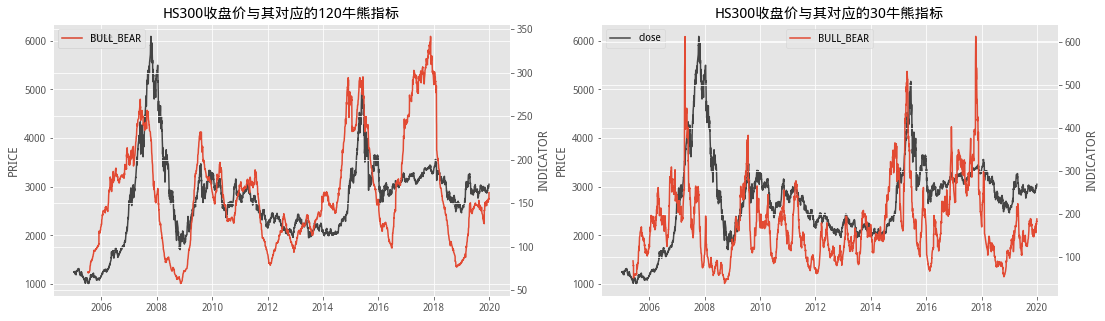

In [263]:

fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(1,2,1)
ax.set_title('HS300收盘价与其对应的120牛熊指标')
ax.plot(df['close'],color='black',alpha=0.7)
ax.legend(['close'],loc=2)
ax.set_ylabel('PRICE')

ax1 = ax.twinx()
ax1.plot(indicator_120)
ax1.legend(['BULL_BEAR'])
ax1.set_ylabel('INDICATOR')


ax2 =fig.add_subplot(1,2,2)

ax2.set_title('HS300收盘价与其对应的30牛熊指标')
ax2.plot(df['close'],color='black',alpha=0.7)
ax2.legend(['close'],loc=2)
ax2.set_ylabel('PRICE')

ax3=ax2.twinx()
ax3.plot(indicator_30)
ax3.legend(['BULL_BEAR'])
ax3.set_ylabel('INDICATOR')
plt.show()

# <font color=red>借鉴双均线策略思想设计“直接牛熊”策略</font>

择时模型都存在一个参数寻优的过程，而过拟合是量化模型所必须去研究和克服的。直接牛熊择时策略在参数选择上采用的是较宽的网格搜索，策略存在两个参数，分别是短期和长期牛熊指标的计算窗口长度。具体操作上，短期窗口长度参数的测试区间为 30 日至 60 日，间隔为 5 日；长期窗口长度参数测试区间为 120 日至 250 日，间隔为 10 日。采用夏普比率对选择不同参数的策略进行评价。同时，对于这种参数选择方法，进行过拟合测试。

基于组合对称交叉验证(CSCV)框架计算策略的过拟合概率(PBO)的方法，这是一种较好的检验过拟合的方法。其核心思想并非检验某个参数是否过拟合，而是某类策略的参 数选取方法是否容易带来过拟合。具体到本策略中，CSCV框架测算的是针对直接牛熊策 略的网格寻优方法是否容易带来过拟合。在过拟合检验中，过拟合概率 PBO 的定义为： 样本内最优参数在样本外的夏普比率排名位于后 50%的概率。一般情况下 PBO 概率小于

50%可以认为过拟合概率不高。PBO 越小，回测过拟合概率越低。

## <font color=red>上证 50 直接牛熊择时效果</font>

上证 50 短期牛熊和长期牛熊最优窗口长度为 30 日和 140 日。直接牛熊策略从过拟合检验图中可以看出，在各种不同分割方法下，相对排名基本都集中于 12.5%附近，其中在总 样本 8 等分的情况下，过拟合概率 PBO 为 0.43%，可以认为其过拟合概率较低。

In [286]:
# 网格寻参
symbol = '000016.XSHG'
start_date,end_date = '2005-06-01','2019-12-31'

ret_dict = {} # 储存各指标的收益数据
annual_ret_dict = {}
short = range(30,61,5) 
long = range(120,251,10)

for p in list(itertools.product(short,long)):
    
    fast = p[0]
    slow = p[1]
    # 初始化
    bullbear = BullBearSingal(symbol,start_date,end_date,fast,slow)

    # 计算信号
    bullbear.GetSingal()

    # 回测
    bt = BackTest(bullbear.Data['close'],bullbear.Singal)
    ret_dict[f'{fast}-{slow}'] = bt.algorithm_ret
    annual_ret_dict[f'{fast}-{slow}'] = bt.strategy_performance().loc['annual_return','algorithm_cum']

2020-06-12 15:22:31,980 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:31,980 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:22:36,208 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:36,208 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:22:40,501 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:40,501 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:22:44,902 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:44,902 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:22:49,322 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:49,322 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:22:53,706 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:53,706 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:22:57,956 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:22:57,956 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:02,209 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:02,209 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:34,902 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:34,902 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:39,205 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:39,205 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:43,420 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:43,420 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:47,709 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:47,709 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:52,069 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:52,069 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:23:56,307 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:23:56,307 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:00,510 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:00,510 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:04,803 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:04,803 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:36,015 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:36,015 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:40,302 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:40,302 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:44,635 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:44,635 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:48,904 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:48,904 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:53,101 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:53,101 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:24:57,416 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:24:57,416 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 15:25:01,594 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 15:25:01,594 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

获取w: 100%|██████████| 924/924 [00:27<00:00, 33.39it/s]


年化收益最优参数:30-140
6等分情况下,过拟合概率为0.0
8等分情况下,过拟合概率为0.043
10等分情况下,过拟合概率为0.016
12等分情况下,过拟合概率为0.0


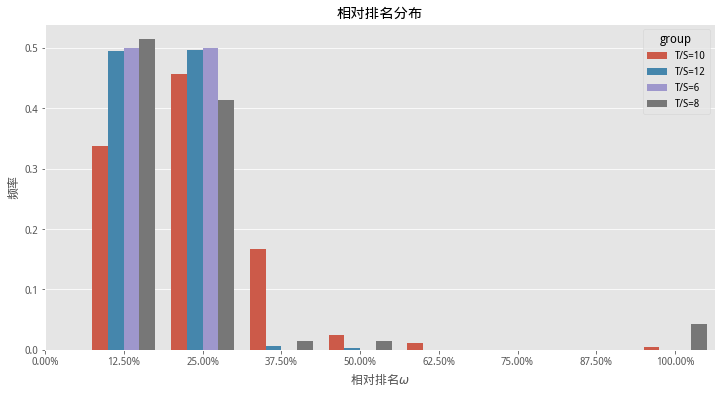

In [287]:
# 过拟合检测
ret_df = pd.concat(ret_dict,axis=1) # 收益表

w_dict,pbo_dict = GetW(ret_df,[6,8,10,12])
df = pd.concat(w_dict,axis=1)

print('年化收益最优参数:%s'%max(annual_ret_dict,key=annual_ret_dict.get))

for a,b in pbo_dict.items():
    print(f'{a}等分情况下,过拟合概率为{b:.2}')
    
plot_dist_bar(df)

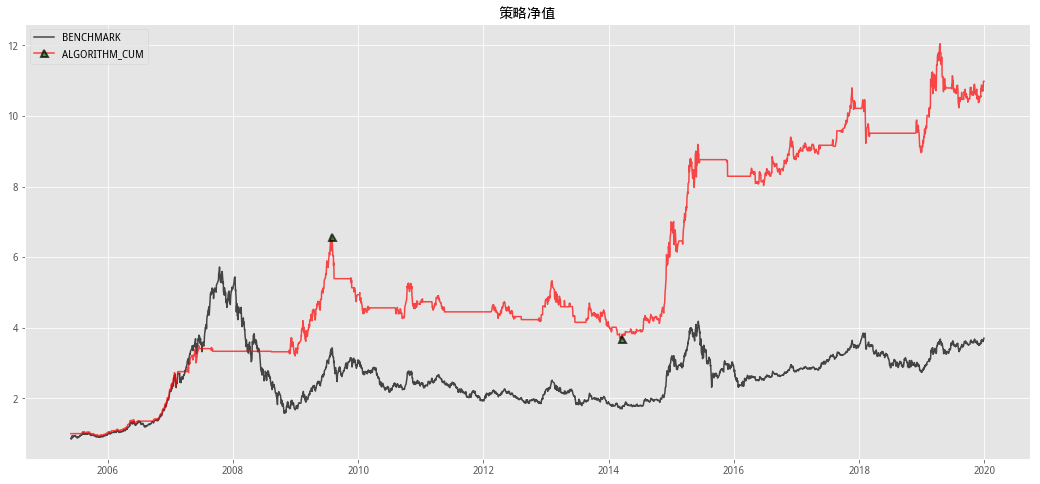

风险指标


,algorithm_cum,benchmark
annual_return,0.185432,0.108348
return_volatility,0.175086,0.276625
sharpe_ratio,0.066735,0.032162
max_drawdown,-0.440849,-0.724059
relative_return,0.077084,0.000000
relative_volatility,-0.101540,0.000000
relative_drawdown,0.283210,0.000000
info_ratio,0.238777,NaN
trade_count,56.000000,NaN
win_count,29.000000,NaN


分年度风险指标


,annual_return,return_volatility,sharpe_ratio,max_drawdown,relative_return,relative_volatility,relative_drawdown,info_ratio
2005,0.037920,0.121693,0.023075,-0.119448,-0.153566,-0.070165,5.134781e-16,-0.658122
2006,1.252986,0.196967,0.266340,-0.076151,-0.059139,-0.023116,5.471646e-02,-0.203119
2007,0.521547,0.232111,0.121346,-0.142361,-0.869729,-0.131681,5.788924e-02,-2.022755
2008,-0.003397,0.127653,0.002321,-0.138461,0.678683,-0.363963,5.713265e-01,1.339091
2009,0.460161,0.265214,0.098305,-0.277586,-0.355420,-0.062051,1.209357e-03,-0.845842
2010,-0.041675,0.176985,-0.009582,-0.146432,0.180565,-0.070625,1.469377e-01,0.615073
2011,-0.063260,0.086098,-0.045094,-0.094625,0.140505,-0.116977,1.826462e-01,0.626934
2012,0.081547,0.131696,0.041599,-0.118601,-0.090412,-0.062105,6.495998e-02,-0.378425
2013,-0.150064,0.205548,-0.043381,-0.241658,0.017152,-0.045282,4.426225e-02,0.053486
2014,0.749724,0.214092,0.171450,-0.087009,0.068540,-0.011108,-1.716042e-03,0.231370


In [288]:
# 初始化
bullbear = BullBearSingal(symbol,start_date,end_date,30,140)

# 计算信号
bullbear.GetSingal()

# 回测
bt = BackTest(bullbear.Data['close'],bullbear.Singal)

# 净值画图
bt.plot_algorithm_cum()

# 风险指标
bt.GetRisk

## <font color=red>沪深300择时效果</font>

沪深 300 短期牛熊和长期牛熊最优窗口长度经网格搜索后分别为 40 日和 130 日。直接牛熊策略在将总样本 8 等分的情况下过拟合概率 PBO 为 0.5，处于一个较为尴尬的位置。与上证 50 类似，沪深 300 直接牛熊策略在 07 年牛市中能捕捉到前半程，在 15 年和 19 年上涨中也均取得不错的捕捉效果，在震荡市中能在保持稳定的基础上缓慢上升。从策略的绩效表现来看，直接牛熊策略的年化收益为 20%。然而虽然其表现优异，但过拟合概率较高，在实际市场中失效可能性也较大。

In [264]:
# 网格寻参
symbol = '000300.XSHG'
start_date,end_date = '2005-06-01','2019-12-31'

ret_dict = {} # 储存各指标的收益数据
annual_ret_dict = {}
short = range(30,61,5) 
long = range(120,251,10)

for p in list(itertools.product(short,long)):
    
    fast = p[0]
    slow = p[1]
    # 初始化
    bullbear = BullBearSingal(symbol,start_date,end_date,fast,slow)

    # 计算信号
    bullbear.GetSingal()

    # 回测
    bt = BackTest(bullbear.Data['close'],bullbear.Singal)
    ret_dict[f'{fast}-{slow}'] = bt.algorithm_ret
    annual_ret_dict[f'{fast}-{slow}'] = bt.strategy_performance().loc['annual_return','algorithm_cum']

2020-06-12 13:33:35,514 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:33:35,514 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:33:39,667 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:33:39,667 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:33:43,910 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:33:43,910 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:33:48,303 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:33:48,303 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:33:52,708 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:33:52,708 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:33:56,838 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:33:56,838 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:01,013 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:01,013 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:05,302 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:05,302 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:36,771 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:36,771 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:41,031 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:41,031 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:45,167 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:45,167 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:49,441 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:49,441 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:53,630 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:53,630 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:34:57,801 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:34:57,801 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:02,036 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:02,036 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:06,266 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:06,266 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:36,155 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:36,155 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:40,415 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:40,415 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:44,538 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:44,538 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:48,703 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:48,703 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:52,832 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:52,832 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:35:56,956 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:35:56,956 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:36:01,237 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:36:01,237 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:36:05,621 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:36:05,621 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

2020-06-12 13:36:09,913 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg'])
Exception: 抱歉，您每分钟最多访问该接口60次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
2020-06-12 13:36:09,913 TuShare <ipython-input-12-118d3fe8324f>:91 wrapper ERROR TuShare exec trade_cal failed, args:(), kwargs:{'exchange': 'SSE', 'start_date': '20050104', 'end_date': '20191231'}, try again.
Traceback (most recent call last):
  File "<ipython-input-12-118d3fe8324f>", line 85, in wrapper
    return m(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tushare/pro/client.py", line 43, in query
    raise Exception(result['msg

获取w: 100%|██████████| 924/924 [00:13<00:00, 70.42it/s]


年化收益最优参数:40-130
6等分情况下,过拟合概率为0.65
8等分情况下,过拟合概率为0.5
10等分情况下,过拟合概率为0.61
12等分情况下,过拟合概率为0.55


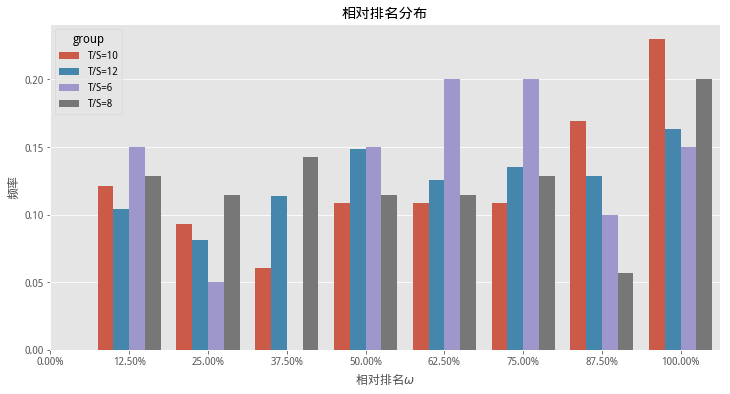

In [283]:
# 过拟合检测
ret_df = pd.concat(ret_dict,axis=1) # 收益表

w_dict,pbo_dict = GetW(ret_df,[6,8,10,12])
df = pd.concat(w_dict,axis=1)

print('年化收益最优参数:%s'%max(annual_ret_dict,key=annual_ret_dict.get))

for a,b in pbo_dict.items():
    print(f'{a}等分情况下,过拟合概率为{b:.2}')
    
plot_dist_bar(df)

使用最优参数回测40-130进行回测

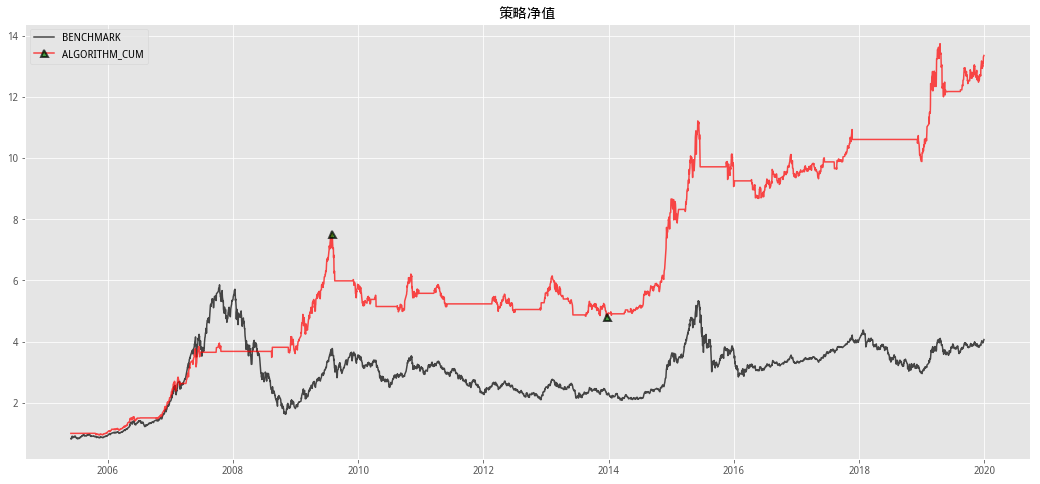

风险指标


,algorithm_cum,benchmark
annual_return,0.202006,0.118991
return_volatility,0.173631,0.274489
sharpe_ratio,0.072269,0.034491
max_drawdown,-0.361405,-0.723038
relative_return,0.083015,0.000000
relative_volatility,-0.100858,0.000000
relative_drawdown,0.361633,0.000000
info_ratio,0.259523,NaN
trade_count,45.000000,NaN
win_count,30.000000,NaN


分年度风险指标


,annual_return,return_volatility,sharpe_ratio,max_drawdown,relative_return,relative_volatility,relative_drawdown,info_ratio
2005,0.061052,0.082337,0.047920,-0.055167,-0.121191,-0.127314,0.062737,-0.531633
2006,1.131128,0.190871,0.256075,-0.085010,-0.122433,-0.031858,0.053145,-0.426543
2007,0.734688,0.279514,0.133180,-0.157585,-0.962108,-0.089257,0.051435,-2.080338
2008,0.016182,0.162112,0.011297,-0.132929,0.688949,-0.323224,0.583082,1.356732
2009,0.528549,0.266434,0.108801,-0.277811,-0.416067,-0.059123,-0.025169,-1.007909
2010,-0.049464,0.186906,-0.011188,-0.145255,0.070579,-0.064732,0.149744,0.229226
2011,-0.064097,0.075130,-0.053164,-0.123820,0.208810,-0.130846,0.192605,0.943417
2012,0.070434,0.125840,0.038018,-0.107459,-0.031325,-0.077883,0.116595,-0.130901
2013,-0.130172,0.172265,-0.045582,-0.218257,-0.048502,-0.050407,0.003337,-0.173791
2014,0.791854,0.164097,0.229269,-0.048342,0.248905,-0.028772,0.048853,0.994926


In [289]:
# 初始化
bullbear = BullBearSingal(symbol,start_date,end_date,40,130)

# 计算信号
bullbear.GetSingal()

# 回测
bt = BackTest(bullbear.Data['close'],bullbear.Singal)

# 净值画图
bt.plot_algorithm_cum()

# 风险指标
bt.GetRisk

# <font color=red>牛熊指标在行业轮动中的应用</font>

“月度牛熊指标”，即将每个月的数据单 独计算出一个牛熊指标，每个月有且仅有一个牛熊指标,将各个行业指数的短期牛熊指标都进行变化率处理， 即计算本期的牛熊指标相对于上一期的变化率，并做多那些变化率相对较大行业。

我们以申万一级行业为标的，研究横截面上利用月度牛熊指标变化率是否能选出表现较好 的行业，测试方法为: 
1. 观察期和持有期均设为一个月，计算出每个月所有行业指数月份内的平均换手率以及波动率，进而计算出月度牛熊指标，以及月度牛熊指标相对于上个月的环比变化率。行业轮 动研究中我们计算牛熊指标时使用的换手率为自由流通换手率。 
2. 在每个月底，根据此月所有一级行业月度牛熊指标变化率的大小进行升序排序，取前 5 名作为多头组合在月初进行等权配置，考察其净值走势。同时取后 5 名作为空头组合等权配置进行比较。

In [2]:
# 获取计算想关数据
def QuerySWData(ts_code: str, start_date: str, end_date: str) -> pd.DataFrame:

    daily_df = distributed_query(
        QuerySWDailyPrice, ts_code, start_date, end_date, fields="", limit=4000)
    valuation_df = distributed_query(
        QuerySWDailyValuation,
        ts_code,
        start_date,
        end_date,
        fields="",
        limit=4000)
    
    df = pd.merge(valuation_df, daily_df, on=['code', 'date'])
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

# 获取日度数据
def QuerySWDailyPrice(ts_code: str, start_date: str, end_date: str,
                      fields: str) -> pd.DataFrame:

    start_date = parse(start_date).strftime('%Y-%m-%d')
    end_date = parse(end_date).strftime('%Y-%m-%d')

    q = query(finance.SW1_DAILY_PRICE.date, finance.SW1_DAILY_PRICE.code,
              finance.SW1_DAILY_PRICE.close,
              finance.SW1_DAILY_PRICE.change_pct).filter(
                  finance.SW1_DAILY_PRICE.code == ts_code,
                  finance.SW1_DAILY_PRICE.date >= start_date,
                  finance.SW1_DAILY_PRICE.date <= end_date)

    return finance.run_query(q)

# 获取衍生数据
def QuerySWDailyValuation(ts_code: str, start_date: str, end_date: str,
                          fields: str) -> pd.DataFrame:

    start_date = parse(start_date).strftime('%Y-%m-%d')
    end_date = parse(end_date).strftime('%Y-%m-%d')

    q = query(finance.SW1_DAILY_VALUATION.date,
              finance.SW1_DAILY_VALUATION.code,
              finance.SW1_DAILY_VALUATION.turnover_ratio).filter(
                  finance.SW1_DAILY_VALUATION.code == ts_code,
                  finance.SW1_DAILY_VALUATION.date >= start_date,
                  finance.SW1_DAILY_VALUATION.date <= end_date)

    return finance.run_query(q)

In [22]:
# 月度熊牛指标计算
def cal_indicator(df:pd.DataFrame)->pd.DataFrame:
    
    return df['turnover_ratio'].mean() / df['change_pct'].std()

# 计算月度
def cal_mret(df:pd.DataFrame)->pd.DataFrame:
    
    return df['close'][-1] / df['close'][0] - 1

# 获取完整的行业月度收益、指标
def GetSWindicator(start_date:str,end_date:str)->list:
    '''
    start_date/end_date:yyyymmdd
    '''
    codes = get_industries('sw_l1').index.tolist()
    indictor_dic = {}
    m_ret_dict = {}
    for code in tqdm(codes,desc='下载中'):
        df = QuerySWData(code,start_date,end_date)
        m_ret_dict[code] = df.groupby(pd.Grouper(level='date',freq='M')).apply(cal_mret)
        indictor_dic[code] = df.groupby(pd.Grouper(level=0,freq='M')).apply(cal_indicator)
    return pd.concat(indictor_dic,axis=1),pd.concat(m_ret_dict,axis=1)


# 获取策略收益
def GetAlgorithmRet(flag:pd.DataFrame,next_ret:pd.DataFrame)->pd.DataFrame:
    
    return (flag * next_ret).apply(lambda x:x[x!=0].mean(),axis=1).fillna(method='ffill')
    

In [23]:
indicator_df,ret = GetSWindicator('20060101','20191231')

下载中: 100%|██████████| 34/34 [00:07<00:00,  4.41it/s]


In [29]:
indicator_df = indicator_df.pct_change().iloc[1:] # 计算环比 去除前序期
rank_indicator = indicator_df.rank(axis=1) # 每月度排名

next_ret = ret.shift(-1) # 下期收益
next_ret = next_ret.iloc[1:] # 去除前序期

In [34]:
# 持有筛选
long_ = (rank_indicator <= 5) # 多头 升序前5

short_ = rank_indicator.apply(lambda x:x>(max(x)-5),axis=1) # 升序 后5

long_ret = GetAlgorithmRet(long_,next_ret) # 多头收益

short_ret = GetAlgorithmRet(short_,next_ret) # 空头收益

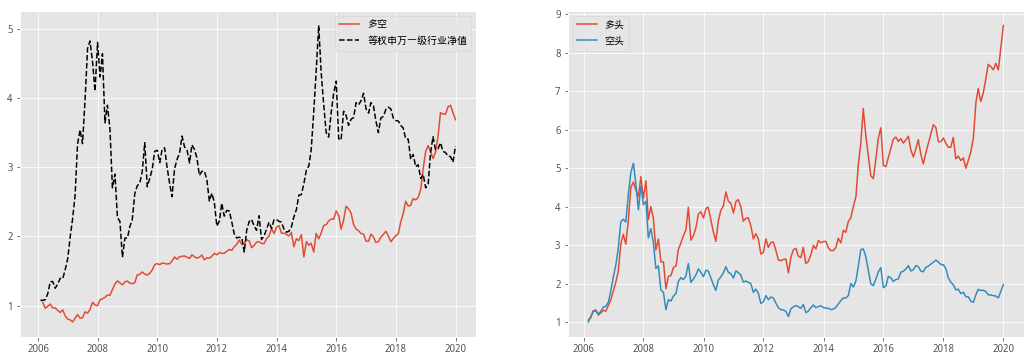

In [71]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot((1+(long_ret - short_ret)).cumprod(),label='多空')
ax1.plot((1+ret.mean(axis=1)).cumprod(),label='等权申万一级行业净值',ls='--',color='black')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot((1+long_ret).cumprod(),label='多头')
ax2.plot((1+short_ret).cumprod(),label='空头')
plt.legend()